Количество записей в таблицах Postgres и статей в Elastic
--------------------

In [6]:
import pandas as pd
import psycopg2 as pg
from elasticsearch import Elasticsearch
# from pandasticsearch import Select
import os
import sys
import ipywidgets as w
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
# import plotly.graph_objects as go

# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

pg_con = pg.connect(os.getenv('RGDSN'))
es_con = Elasticsearch('http://es01:9200')

def get_counts():
    """ Возвращает число записей в таблицах Postgress и индексах Elastic"""
    counts = {
        "PG: rubrics" : pd.read_sql('SELECT count(1) FROM rubrics', pg_con)['count'][0],
        "PG: rubrics_objects" : pd.read_sql('SELECT count(1) FROM rubrics_objects', pg_con)['count'][0],
        "PG: articles" : pd.read_sql_query('SELECT count(1) FROM articles', pg_con)['count'][0],
        "articles: migration_status = 'error'" : pd.read_sql("SELECT count(1) FROM articles WHERE migration_status = 'error'", pg_con)['count'][0],
        "articles: process_status   = 'error'" : pd.read_sql("SELECT count(1) FROM articles WHERE process_status = 'error'", pg_con)['count'][0],
        "articles: process_status IS NULL    " : pd.read_sql("SELECT count(1) FROM articles WHERE process_status IS NULL", pg_con)['count'][0],
        "articles: process_status   = 'success'" : pd.read_sql("SELECT count(1) FROM articles WHERE process_status = 'success'", pg_con)['count'][0],
        "articles: elastic_status   = 'indexed'" : pd.read_sql("SELECT count(1) FROM articles WHERE elastic_status = 'indexed'", pg_con)['count'][0],
        "ES: articles" : es_con.count(index='articles')['count'],
    }
    return counts

def display_counts():
    counts = get_counts()
    display( pd.DataFrame.from_dict(counts,orient='index', columns=['count']) )
    

In [2]:
%%time
display_counts()

,count
PG: rubrics,1151
PG: rubrics_objects,3122214
PG: articles,1227897
articles: migration_status = 'error',0
articles: process_status = 'error',0
articles: process_status IS NULL,0
articles: process_status = 'success',1227897
articles: elastic_status = 'indexed',1227897
ES: articles,1227897


CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 1.41 s


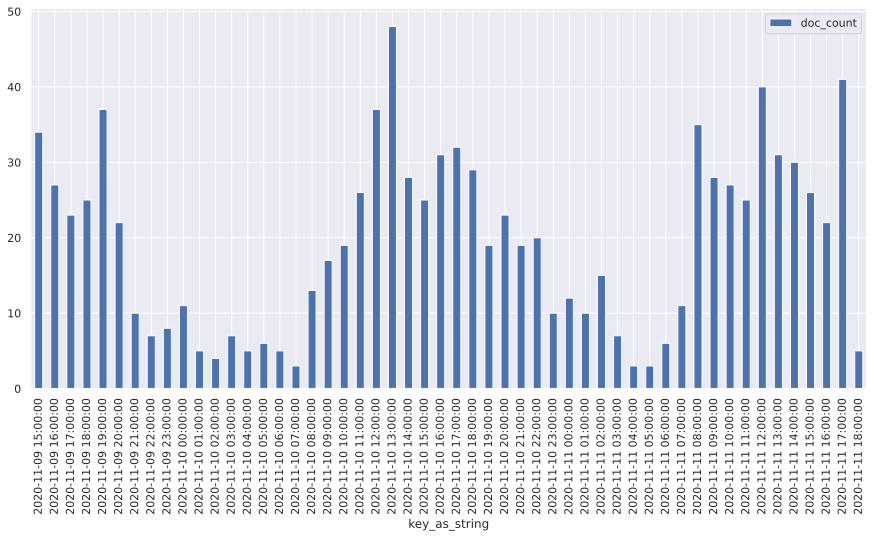

In [7]:

body = {
    "size": 0,
    "query": {
        "range": {
            "date_modified": {
                "from": "now-2d/h"
           }
        }
    },
    "aggs": {
        "articles_over_time": {
            "date_histogram": {
                "field": "date_modified",
                "calendar_interval": "hour"
            }
        }
    }
}


result = es_con.search(body,'articles')
buckets = result['aggregations']['articles_over_time']['buckets']
df = pd.DataFrame.from_dict(buckets)
# display(df)


mpl.rcParams['figure.figsize'] = [15.0, 7.0]
# mpl.rcParams['figure.dpi'] = 72
# mpl.rcParams['savefig.dpi'] = 100
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['legend.fontsize'] = 'medium'
# mpl.rcParams['figure.titlesize'] = 'medium'
%config InlineBackend.figure_format = 'svg'
df.plot(kind='bar',x='key_as_string',y='doc_count');


## Очистка ошибок в поле articles.migration_status

In [7]:
pd.read_sql_query("UPDATE articles  SET migration_status = NULL WHERE migration_status = 'error' RETURNING obj_id, migration_status", pg_con)

,obj_id,migration_status
0,1984177,None
1,1983123,None
2,1983126,None


Загружаем идентификаторы статей из Postgres
-----------------------

In [4]:
%%time
ids_pg_df = pd.read_sql('SELECT obj_id FROM articles limit 2000000', pg_con)
# mem_mb = ids_pg_df.memory_usage(deep=True).sum()/1024/1024
mem_mb = sys.getsizeof(ids_pg_df)/1024/1024
print(f'Память под идентификаторы = {mem_mb:.2f} Mb')
display(ids_pg_df)

Память под идентификаторы = 74.26 Mb


,obj_id
0,125688
1,127125
2,127413
3,1702389
4,126881
...,...
1226066,127213
1226067,127895
1226068,125465
1226069,126115


CPU times: user 532 ms, sys: 152 ms, total: 684 ms
Wall time: 1.6 s


Загружаем идентификаторы статей из Еластик
-----------------------

In [5]:
def load_field_values(index_name:str, field_name:str, fetch_size:int) ->list:
    """Возвращает список значений поля из инедкса Эластик"""
    
    # Количество объектов
    es_count = es_con.count(index=index_name)['count']
    progress = w.IntProgress(min=0, max=es_count)
    label = w.Label()
    hbox = w.HBox([progress, label])
    display(hbox)
    start = time.time()
    
    def show_progress():
        progress.value = len(ids)
        label.value = f'{len(ids)}/{es_count} время {time.time()-start:.1f}/{(time.time()-start)*es_count/len(ids):.1f} sec'

        
    
    ids = []

    res = es_con.sql.query({"query": f"select {field_name} from {index_name}", "fetch_size":fetch_size })
    ids.extend(row[0] for row in res['rows'])
    cursor = res.get('cursor')
    show_progress()

    while cursor:
        res = es_con.sql.query({"cursor": cursor})
        ids.extend(row[0] for row in res['rows'])
        cursor = res.get('cursor')
        show_progress()

    cursor_clearing_result = "didn't try"
    if cursor:
        cursor_clearing_result = es_con.sql.clear_cursor({"cursor":cursor})

    return ids



In [6]:
%%time
ids_es = load_field_values(index_name='articles', field_name='obj_id', fetch_size='10000')
mb = sys.getsizeof(ids_es)/1024/1024
print(f'len={len(ids_es)} {mb} mb')

len=1226068 9.957992553710938 mb
CPU times: user 2.3 s, sys: 145 ms, total: 2.44 s
Wall time: 2min 37s


In [8]:
ids_es_set = set(ids_es)
len(ids_es_set)

1226068

In [13]:
ids_pg_set = set(ids_pg_df['obj_id'].to_list())
len(ids_pg_set)

1226071

In [14]:
ids_pg_set - ids_es_set

{'1983123', '1983126', '1984177'}